<a href="https://colab.research.google.com/github/manoelcamposneto/TarefaDL_03/blob/main/C%C3%B3pia_de_Tarefa_03_202200470051.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMOSTRA 1
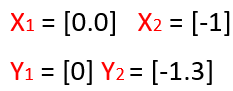


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras import backend as k
from keras import losses
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error

#Initialize all weights to match the values adopted in the example at
#https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/ 
#Initialise kernel (weights matrix) to required value
def kernel_init_layer1(shape,dtype='float'):
    # In this simple example, assume that the shape is (2, 2) 
    # and create a fixed array with this dimension for layer 1
    kernel = np.array([[0.1, 0.3],[-0.4, 0.2]])
    return kernel 

#Initialise kernel (weights matrix) to required value
def kernel_init_layer2(shape,dtype='float'):
    # In this simple example, assume that the shape is (2, 2)
    # and create a fixed array with this dimension for layer 2
    kernel = np.array([[0.4, -0.4], [0.2, 0.7]])
    return kernel 

#Initialise kernel (bias vector) to required value
def kernel_init_bias1(shape,dtype='float'):
    # In this simple example, assume that the shape is (1, 2)
    # and create a fixed array with this dimension for the 
    # bias vector of layer 1
    kernel = np.array([-0.4, 0.8]) #both neurons with the same value
    return kernel 

#Initialise kernel (bias vector) to required value
def kernel_init_bias2(shape,dtype='float'):
    # In this simple example, assume that the shape is (1, 2)
    # and create a fixed array with this dimension for the 
    # bias vector of layer 2
    kernel = np.array([0.80, 0.2]) #both neurons with the same value
    return kernel 

# from https://stackoverflow.com/questions/66221788/tf-gradients-is-not-supported-when-eager-execution-is-enabled-use-tf-gradientta
# TF 2 does not use "eager" execution, so disable it:
tf.compat.v1.disable_eager_execution()

#Define the neural network model with dense layers. Syntax:
#https://keras.io/api/layers/core_layers/dense/
#The sigmoid activation function in Keras is the standard logistic function 1/(1+exp(-x)).
#https://keras.io/api/layers/activations/
model = Sequential()
model.add(Dense(2, input_dim=2, use_bias=True,  bias_initializer=kernel_init_bias1,
        kernel_initializer=kernel_init_layer1, activation='sigmoid'))
model.add(Dense(2, use_bias=True,  bias_initializer=kernel_init_bias2, 
        kernel_initializer=kernel_init_layer2, activation='sigmoid'))
model.summary() # display the architecture

# We are not going to use a Keras optimizer. Define a learning rate:
learning_rate = 1  #you can change to 0.5 or any other reasonable value

#now compile the model, informing loss and performanc metrics that
#should be computed along the training
model.compile(loss='mse', metrics=['accuracy'])

# Begin TensorFlow
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.initialize_all_variables())

print("===START TRAINING THE NETWORK:===")
steps = 3 # steps of gradient descent

model.optimizer.lr = learning_rate

for s in range(steps):
    print('Learning rate = ', k.get_value(model.optimizer.lr))
    print(" ############ Step = " + str(s) + " ############")
    print("1) ===BEFORE using any GRADIENT:===")
    #define input and target vectors, and also inform it to the loss function object
    #in this code we will keep the same inputs and targets along the steps, but the inputs and
    #targets can change when we go, for instance, through the training set
    inputs = np.array([[0.0, -1]]) #define the input for the current iteration (step)
    outputs = model.predict(inputs) #forward pass
    #define the target vector for the current iteration (step)
    targets = np.array([[0, -1.3]]) #notice that a sigmoid can output within range [0, 1]
    mse = mean_squared_error(targets, outputs) #calculate MSE
    #initialize loss object to be later incorporated to the gradients object that
    #enables the calculation of the symbolic gradients
    loss = losses.mean_squared_error(targets, model.output)
    #  ===== Obtain symbolic gradient to calculate numerical gradients =====
    gradients = k.gradients(loss, model.trainable_weights) #inform loss and weights
    if False: #enable with True in case you want to see the objects
        print("List of tensors representing the symbolic gradients:")
        for i in range(len(gradients)):
            print('symbolic gradient[',i,']=',gradients[i])
    print('Network input [x1, x2]:\n', inputs)
    print('Network output [out_o1, out_o2]:\n', outputs)
    print("targets:\n", targets)
    #show weights at the beginning of iteration s
    print('weights at the beginning of this step')
    for i in range(len(model.trainable_weights)):
        #note that model.trainable_weights[i] is an object of
        # <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable
        #therefore (see e.g. https://stackoverflow.com/questions/33679382/how-do-i-get-the-current-value-of-a-variable )
        #you need to obtain its value via a TF session:
        print('weights[',i,']=',sess.run(model.trainable_weights[i]))
    print("MSE with the initial weights:", mse)

    print("2) ===After applying GRADIENT:===")
    print("------------- Results for step (iteration) =", s)
    # ===== Calculate numerical gradient from symbolic gradients =====
    # evaluated_gradients is a list, show its contents:
    evaluated_gradients = sess.run(gradients, feed_dict={model.input: inputs})
    print('Gradients g to be used in new_weights = current_weights - learning_rate*g')
    for i in range(len(evaluated_gradients)):
        print('gradients[',i,']=',evaluated_gradients[i])

    # Apply ("step down") the gradient for each layer, subtracting the gradients
    # from current weights scaled by the learning rate:
    for i in range(len(model.trainable_weights)):
        sess.run(tf.compat.v1.assign_sub(model.trainable_weights[i], learning_rate*evaluated_gradients[i]))

    #show weights after gradient propagation of iteration s
    print('weights after gradient propagation in this step')
    for i in range(len(model.trainable_weights)):
        print('weights[',i,']=',sess.run(model.trainable_weights[i]))

    # print the MSE with new weights:
    outputs = model.predict(inputs)
    mse = mean_squared_error(targets, outputs)
    print("MSE with the new weights:", mse)

#Collect and show final results
final_outputs = model.predict(inputs)
final_mse = mean_squared_error(targets, final_outputs)

print("\n ===AFTER executing all GRADIENT descent steps===")
#show weights at the end of training
for i in range(len(model.trainable_weights)):
    #note that model.trainable_weights[i] is an object of
    # <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable
    #therefore (see e.g. https://stackoverflow.com/questions/33679382/how-do-i-get-the-current-value-of-a-variable )
    #you need to obtain its value via a TF session:
    print('final weights[',i,']=',sess.run(model.trainable_weights[i]))
print("outputs:\n", final_outputs)
print("targets:\n", targets)
print("Final MSE = ", final_mse)

# AMOSTRA 2
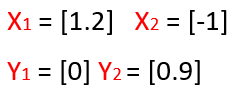

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras import backend as k
from keras import losses
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error

#Initialize all weights to match the values adopted in the example at
#https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/ 
#Initialise kernel (weights matrix) to required value
def kernel_init_layer1(shape,dtype='float'):
    # In this simple example, assume that the shape is (2, 2) 
    # and create a fixed array with this dimension for layer 1
    kernel = np.array([[0.1, 0.3],[-0.4, 0.2]])
    return kernel 

#Initialise kernel (weights matrix) to required value
def kernel_init_layer2(shape,dtype='float'):
    # In this simple example, assume that the shape is (2, 2)
    # and create a fixed array with this dimension for layer 2
    kernel = np.array([[0.4, -0.4], [0.2, 0.7]])
    return kernel 

#Initialise kernel (bias vector) to required value
def kernel_init_bias1(shape,dtype='float'):
    # In this simple example, assume that the shape is (1, 2)
    # and create a fixed array with this dimension for the 
    # bias vector of layer 1
    kernel = np.array([-0.4, 0.8]) #both neurons with the same value
    return kernel 

#Initialise kernel (bias vector) to required value
def kernel_init_bias2(shape,dtype='float'):
    # In this simple example, assume that the shape is (1, 2)
    # and create a fixed array with this dimension for the 
    # bias vector of layer 2
    kernel = np.array([0.80, 0.2]) #both neurons with the same value
    return kernel 

# from https://stackoverflow.com/questions/66221788/tf-gradients-is-not-supported-when-eager-execution-is-enabled-use-tf-gradientta
# TF 2 does not use "eager" execution, so disable it:
tf.compat.v1.disable_eager_execution()

#Define the neural network model with dense layers. Syntax:
#https://keras.io/api/layers/core_layers/dense/
#The sigmoid activation function in Keras is the standard logistic function 1/(1+exp(-x)).
#https://keras.io/api/layers/activations/
model = Sequential()
model.add(Dense(2, input_dim=2, use_bias=True,  bias_initializer=kernel_init_bias1,
        kernel_initializer=kernel_init_layer1, activation='sigmoid'))
model.add(Dense(2, use_bias=True,  bias_initializer=kernel_init_bias2, 
        kernel_initializer=kernel_init_layer2, activation='sigmoid'))
model.summary() # display the architecture

# We are not going to use a Keras optimizer. Define a learning rate:
learning_rate = 1  #you can change to 0.5 or any other reasonable value

#now compile the model, informing loss and performanc metrics that
#should be computed along the training
model.compile(loss='mse', metrics=['accuracy'])

# Begin TensorFlow
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.initialize_all_variables())

print("===START TRAINING THE NETWORK:===")
steps = 3 # steps of gradient descent

model.optimizer.lr = learning_rate

for s in range(steps):
    print('Learning rate = ', k.get_value(model.optimizer.lr))
    print(" ############ Step = " + str(s) + " ############")
    print("1) ===BEFORE using any GRADIENT:===")
    #define input and target vectors, and also inform it to the loss function object
    #in this code we will keep the same inputs and targets along the steps, but the inputs and
    #targets can change when we go, for instance, through the training set
    inputs = np.array([[1.2, -1]]) #define the input for the current iteration (step)
    outputs = model.predict(inputs) #forward pass
    #define the target vector for the current iteration (step)
    targets = np.array([[0, 0.9]]) #notice that a sigmoid can output within range [0, 1]
    mse = mean_squared_error(targets, outputs) #calculate MSE
    #initialize loss object to be later incorporated to the gradients object that
    #enables the calculation of the symbolic gradients
    loss = losses.mean_squared_error(targets, model.output)
    #  ===== Obtain symbolic gradient to calculate numerical gradients =====
    gradients = k.gradients(loss, model.trainable_weights) #inform loss and weights
    if False: #enable with True in case you want to see the objects
        print("List of tensors representing the symbolic gradients:")
        for i in range(len(gradients)):
            print('symbolic gradient[',i,']=',gradients[i])
    print('Network input [x1, x2]:\n', inputs)
    print('Network output [out_o1, out_o2]:\n', outputs)
    print("targets:\n", targets)
    #show weights at the beginning of iteration s
    print('weights at the beginning of this step')
    for i in range(len(model.trainable_weights)):
        #note that model.trainable_weights[i] is an object of
        # <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable
        #therefore (see e.g. https://stackoverflow.com/questions/33679382/how-do-i-get-the-current-value-of-a-variable )
        #you need to obtain its value via a TF session:
        print('weights[',i,']=',sess.run(model.trainable_weights[i]))
    print("MSE with the initial weights:", mse)

    print("2) ===After applying GRADIENT:===")
    print("------------- Results for step (iteration) =", s)
    # ===== Calculate numerical gradient from symbolic gradients =====
    # evaluated_gradients is a list, show its contents:
    evaluated_gradients = sess.run(gradients, feed_dict={model.input: inputs})
    print('Gradients g to be used in new_weights = current_weights - learning_rate*g')
    for i in range(len(evaluated_gradients)):
        print('gradients[',i,']=',evaluated_gradients[i])

    # Apply ("step down") the gradient for each layer, subtracting the gradients
    # from current weights scaled by the learning rate:
    for i in range(len(model.trainable_weights)):
        sess.run(tf.compat.v1.assign_sub(model.trainable_weights[i], learning_rate*evaluated_gradients[i]))

    #show weights after gradient propagation of iteration s
    print('weights after gradient propagation in this step')
    for i in range(len(model.trainable_weights)):
        print('weights[',i,']=',sess.run(model.trainable_weights[i]))

    # print the MSE with new weights:
    outputs = model.predict(inputs)
    mse = mean_squared_error(targets, outputs)
    print("MSE with the new weights:", mse)

#Collect and show final results
final_outputs = model.predict(inputs)
final_mse = mean_squared_error(targets, final_outputs)

print("\n ===AFTER executing all GRADIENT descent steps===")
#show weights at the end of training
for i in range(len(model.trainable_weights)):
    #note that model.trainable_weights[i] is an object of
    # <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable
    #therefore (see e.g. https://stackoverflow.com/questions/33679382/how-do-i-get-the-current-value-of-a-variable )
    #you need to obtain its value via a TF session:
    print('final weights[',i,']=',sess.run(model.trainable_weights[i]))
print("outputs:\n", final_outputs)
print("targets:\n", targets)
print("Final MSE = ", final_mse)

# AMOSTRA 3
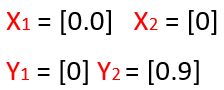

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras import backend as k
from keras import losses
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error

#Initialize all weights to match the values adopted in the example at
#https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/ 
#Initialise kernel (weights matrix) to required value
def kernel_init_layer1(shape,dtype='float'):
    # In this simple example, assume that the shape is (2, 2) 
    # and create a fixed array with this dimension for layer 1
    kernel = np.array([[0.1, 0.3],[-0.4, 0.2]])
    return kernel 

#Initialise kernel (weights matrix) to required value
def kernel_init_layer2(shape,dtype='float'):
    # In this simple example, assume that the shape is (2, 2)
    # and create a fixed array with this dimension for layer 2
    kernel = np.array([[0.4, -0.4], [0.2, 0.7]])
    return kernel 

#Initialise kernel (bias vector) to required value
def kernel_init_bias1(shape,dtype='float'):
    # In this simple example, assume that the shape is (1, 2)
    # and create a fixed array with this dimension for the 
    # bias vector of layer 1
    kernel = np.array([-0.4, 0.8]) #both neurons with the same value
    return kernel 

#Initialise kernel (bias vector) to required value
def kernel_init_bias2(shape,dtype='float'):
    # In this simple example, assume that the shape is (1, 2)
    # and create a fixed array with this dimension for the 
    # bias vector of layer 2
    kernel = np.array([0.80, 0.2]) #both neurons with the same value
    return kernel 

# from https://stackoverflow.com/questions/66221788/tf-gradients-is-not-supported-when-eager-execution-is-enabled-use-tf-gradientta
# TF 2 does not use "eager" execution, so disable it:
tf.compat.v1.disable_eager_execution()

#Define the neural network model with dense layers. Syntax:
#https://keras.io/api/layers/core_layers/dense/
#The sigmoid activation function in Keras is the standard logistic function 1/(1+exp(-x)).
#https://keras.io/api/layers/activations/
model = Sequential()
model.add(Dense(2, input_dim=2, use_bias=True,  bias_initializer=kernel_init_bias1,
        kernel_initializer=kernel_init_layer1, activation='sigmoid'))
model.add(Dense(2, use_bias=True,  bias_initializer=kernel_init_bias2, 
        kernel_initializer=kernel_init_layer2, activation='sigmoid'))
model.summary() # display the architecture

# We are not going to use a Keras optimizer. Define a learning rate:
learning_rate = 1  #you can change to 0.5 or any other reasonable value

#now compile the model, informing loss and performanc metrics that
#should be computed along the training
model.compile(loss='mse', metrics=['accuracy'])

# Begin TensorFlow
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.initialize_all_variables())

print("===START TRAINING THE NETWORK:===")
steps = 3 # steps of gradient descent

model.optimizer.lr = learning_rate

for s in range(steps):
    print('Learning rate = ', k.get_value(model.optimizer.lr))
    print(" ############ Step = " + str(s) + " ############")
    print("1) ===BEFORE using any GRADIENT:===")
    #define input and target vectors, and also inform it to the loss function object
    #in this code we will keep the same inputs and targets along the steps, but the inputs and
    #targets can change when we go, for instance, through the training set
    inputs = np.array([[0.0, 0]]) #define the input for the current iteration (step)
    outputs = model.predict(inputs) #forward pass
    #define the target vector for the current iteration (step)
    targets = np.array([[0, 0.9]]) #notice that a sigmoid can output within range [0, 1]
    mse = mean_squared_error(targets, outputs) #calculate MSE
    #initialize loss object to be later incorporated to the gradients object that
    #enables the calculation of the symbolic gradients
    loss = losses.mean_squared_error(targets, model.output)
    #  ===== Obtain symbolic gradient to calculate numerical gradients =====
    gradients = k.gradients(loss, model.trainable_weights) #inform loss and weights
    if False: #enable with True in case you want to see the objects
        print("List of tensors representing the symbolic gradients:")
        for i in range(len(gradients)):
            print('symbolic gradient[',i,']=',gradients[i])
    print('Network input [x1, x2]:\n', inputs)
    print('Network output [out_o1, out_o2]:\n', outputs)
    print("targets:\n", targets)
    #show weights at the beginning of iteration s
    print('weights at the beginning of this step')
    for i in range(len(model.trainable_weights)):
        #note that model.trainable_weights[i] is an object of
        # <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable
        #therefore (see e.g. https://stackoverflow.com/questions/33679382/how-do-i-get-the-current-value-of-a-variable )
        #you need to obtain its value via a TF session:
        print('weights[',i,']=',sess.run(model.trainable_weights[i]))
    print("MSE with the initial weights:", mse)

    print("2) ===After applying GRADIENT:===")
    print("------------- Results for step (iteration) =", s)
    # ===== Calculate numerical gradient from symbolic gradients =====
    # evaluated_gradients is a list, show its contents:
    evaluated_gradients = sess.run(gradients, feed_dict={model.input: inputs})
    print('Gradients g to be used in new_weights = current_weights - learning_rate*g')
    for i in range(len(evaluated_gradients)):
        print('gradients[',i,']=',evaluated_gradients[i])

    # Apply ("step down") the gradient for each layer, subtracting the gradients
    # from current weights scaled by the learning rate:
    for i in range(len(model.trainable_weights)):
        sess.run(tf.compat.v1.assign_sub(model.trainable_weights[i], learning_rate*evaluated_gradients[i]))

    #show weights after gradient propagation of iteration s
    print('weights after gradient propagation in this step')
    for i in range(len(model.trainable_weights)):
        print('weights[',i,']=',sess.run(model.trainable_weights[i]))

    # print the MSE with new weights:
    outputs = model.predict(inputs)
    mse = mean_squared_error(targets, outputs)
    print("MSE with the new weights:", mse)

#Collect and show final results
final_outputs = model.predict(inputs)
final_mse = mean_squared_error(targets, final_outputs)

print("\n ===AFTER executing all GRADIENT descent steps===")
#show weights at the end of training
for i in range(len(model.trainable_weights)):
    #note that model.trainable_weights[i] is an object of
    # <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable
    #therefore (see e.g. https://stackoverflow.com/questions/33679382/how-do-i-get-the-current-value-of-a-variable )
    #you need to obtain its value via a TF session:
    print('final weights[',i,']=',sess.run(model.trainable_weights[i]))
print("outputs:\n", final_outputs)
print("targets:\n", targets)
print("Final MSE = ", final_mse)

# Utilizando learning rate de **(0.5)** para todas as amostras acima

# Amostra 1

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras import backend as k
from keras import losses
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error

#Initialize all weights to match the values adopted in the example at
#https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/ 
#Initialise kernel (weights matrix) to required value
def kernel_init_layer1(shape,dtype='float'):
    # In this simple example, assume that the shape is (2, 2) 
    # and create a fixed array with this dimension for layer 1
    kernel = np.array([[0.1, 0.3],[-0.4, 0.2]])
    return kernel 

#Initialise kernel (weights matrix) to required value
def kernel_init_layer2(shape,dtype='float'):
    # In this simple example, assume that the shape is (2, 2)
    # and create a fixed array with this dimension for layer 2
    kernel = np.array([[0.4, -0.4], [0.2, 0.7]])
    return kernel 

#Initialise kernel (bias vector) to required value
def kernel_init_bias1(shape,dtype='float'):
    # In this simple example, assume that the shape is (1, 2)
    # and create a fixed array with this dimension for the 
    # bias vector of layer 1
    kernel = np.array([-0.4, 0.8]) #both neurons with the same value
    return kernel 

#Initialise kernel (bias vector) to required value
def kernel_init_bias2(shape,dtype='float'):
    # In this simple example, assume that the shape is (1, 2)
    # and create a fixed array with this dimension for the 
    # bias vector of layer 2
    kernel = np.array([0.80, 0.2]) #both neurons with the same value
    return kernel 

# from https://stackoverflow.com/questions/66221788/tf-gradients-is-not-supported-when-eager-execution-is-enabled-use-tf-gradientta
# TF 2 does not use "eager" execution, so disable it:
tf.compat.v1.disable_eager_execution()

#Define the neural network model with dense layers. Syntax:
#https://keras.io/api/layers/core_layers/dense/
#The sigmoid activation function in Keras is the standard logistic function 1/(1+exp(-x)).
#https://keras.io/api/layers/activations/
model = Sequential()
model.add(Dense(2, input_dim=2, use_bias=True,  bias_initializer=kernel_init_bias1,
        kernel_initializer=kernel_init_layer1, activation='sigmoid'))
model.add(Dense(2, use_bias=True,  bias_initializer=kernel_init_bias2, 
        kernel_initializer=kernel_init_layer2, activation='sigmoid'))
model.summary() # display the architecture

# We are not going to use a Keras optimizer. Define a learning rate:
learning_rate = 0.5  #you can change to 0.5 or any other reasonable value

#now compile the model, informing loss and performanc metrics that
#should be computed along the training
model.compile(loss='mse', metrics=['accuracy'])

# Begin TensorFlow
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.initialize_all_variables())

print("===START TRAINING THE NETWORK:===")
steps = 3 # steps of gradient descent

model.optimizer.lr = learning_rate

for s in range(steps):
    print('Learning rate = ', k.get_value(model.optimizer.lr))
    print(" ############ Step = " + str(s) + " ############")
    print("1) ===BEFORE using any GRADIENT:===")
    #define input and target vectors, and also inform it to the loss function object
    #in this code we will keep the same inputs and targets along the steps, but the inputs and
    #targets can change when we go, for instance, through the training set
    inputs = np.array([[0.0, -1]]) #define the input for the current iteration (step)
    outputs = model.predict(inputs) #forward pass
    #define the target vector for the current iteration (step)
    targets = np.array([[0, -1.3]]) #notice that a sigmoid can output within range [0, 1]
    mse = mean_squared_error(targets, outputs) #calculate MSE
    #initialize loss object to be later incorporated to the gradients object that
    #enables the calculation of the symbolic gradients
    loss = losses.mean_squared_error(targets, model.output)
    #  ===== Obtain symbolic gradient to calculate numerical gradients =====
    gradients = k.gradients(loss, model.trainable_weights) #inform loss and weights
    if False: #enable with True in case you want to see the objects
        print("List of tensors representing the symbolic gradients:")
        for i in range(len(gradients)):
            print('symbolic gradient[',i,']=',gradients[i])
    print('Network input [x1, x2]:\n', inputs)
    print('Network output [out_o1, out_o2]:\n', outputs)
    print("targets:\n", targets)
    #show weights at the beginning of iteration s
    print('weights at the beginning of this step')
    for i in range(len(model.trainable_weights)):
        #note that model.trainable_weights[i] is an object of
        # <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable
        #therefore (see e.g. https://stackoverflow.com/questions/33679382/how-do-i-get-the-current-value-of-a-variable )
        #you need to obtain its value via a TF session:
        print('weights[',i,']=',sess.run(model.trainable_weights[i]))
    print("MSE with the initial weights:", mse)

    print("2) ===After applying GRADIENT:===")
    print("------------- Results for step (iteration) =", s)
    # ===== Calculate numerical gradient from symbolic gradients =====
    # evaluated_gradients is a list, show its contents:
    evaluated_gradients = sess.run(gradients, feed_dict={model.input: inputs})
    print('Gradients g to be used in new_weights = current_weights - learning_rate*g')
    for i in range(len(evaluated_gradients)):
        print('gradients[',i,']=',evaluated_gradients[i])

    # Apply ("step down") the gradient for each layer, subtracting the gradients
    # from current weights scaled by the learning rate:
    for i in range(len(model.trainable_weights)):
        sess.run(tf.compat.v1.assign_sub(model.trainable_weights[i], learning_rate*evaluated_gradients[i]))

    #show weights after gradient propagation of iteration s
    print('weights after gradient propagation in this step')
    for i in range(len(model.trainable_weights)):
        print('weights[',i,']=',sess.run(model.trainable_weights[i]))

    # print the MSE with new weights:
    outputs = model.predict(inputs)
    mse = mean_squared_error(targets, outputs)
    print("MSE with the new weights:", mse)

#Collect and show final results
final_outputs = model.predict(inputs)
final_mse = mean_squared_error(targets, final_outputs)

print("\n ===AFTER executing all GRADIENT descent steps===")
#show weights at the end of training
for i in range(len(model.trainable_weights)):
    #note that model.trainable_weights[i] is an object of
    # <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable
    #therefore (see e.g. https://stackoverflow.com/questions/33679382/how-do-i-get-the-current-value-of-a-variable )
    #you need to obtain its value via a TF session:
    print('final weights[',i,']=',sess.run(model.trainable_weights[i]))
print("outputs:\n", final_outputs)
print("targets:\n", targets)
print("Final MSE = ", final_mse)

# Amostra 2

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras import backend as k
from keras import losses
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error

#Initialize all weights to match the values adopted in the example at
#https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/ 
#Initialise kernel (weights matrix) to required value
def kernel_init_layer1(shape,dtype='float'):
    # In this simple example, assume that the shape is (2, 2) 
    # and create a fixed array with this dimension for layer 1
    kernel = np.array([[0.1, 0.3],[-0.4, 0.2]])
    return kernel 

#Initialise kernel (weights matrix) to required value
def kernel_init_layer2(shape,dtype='float'):
    # In this simple example, assume that the shape is (2, 2)
    # and create a fixed array with this dimension for layer 2
    kernel = np.array([[0.4, -0.4], [0.2, 0.7]])
    return kernel 

#Initialise kernel (bias vector) to required value
def kernel_init_bias1(shape,dtype='float'):
    # In this simple example, assume that the shape is (1, 2)
    # and create a fixed array with this dimension for the 
    # bias vector of layer 1
    kernel = np.array([-0.4, 0.8]) #both neurons with the same value
    return kernel 

#Initialise kernel (bias vector) to required value
def kernel_init_bias2(shape,dtype='float'):
    # In this simple example, assume that the shape is (1, 2)
    # and create a fixed array with this dimension for the 
    # bias vector of layer 2
    kernel = np.array([0.80, 0.2]) #both neurons with the same value
    return kernel 

# from https://stackoverflow.com/questions/66221788/tf-gradients-is-not-supported-when-eager-execution-is-enabled-use-tf-gradientta
# TF 2 does not use "eager" execution, so disable it:
tf.compat.v1.disable_eager_execution()

#Define the neural network model with dense layers. Syntax:
#https://keras.io/api/layers/core_layers/dense/
#The sigmoid activation function in Keras is the standard logistic function 1/(1+exp(-x)).
#https://keras.io/api/layers/activations/
model = Sequential()
model.add(Dense(2, input_dim=2, use_bias=True,  bias_initializer=kernel_init_bias1,
        kernel_initializer=kernel_init_layer1, activation='sigmoid'))
model.add(Dense(2, use_bias=True,  bias_initializer=kernel_init_bias2, 
        kernel_initializer=kernel_init_layer2, activation='sigmoid'))
model.summary() # display the architecture

# We are not going to use a Keras optimizer. Define a learning rate:
learning_rate = 0.5  #you can change to 0.5 or any other reasonable value

#now compile the model, informing loss and performanc metrics that
#should be computed along the training
model.compile(loss='mse', metrics=['accuracy'])

# Begin TensorFlow
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.initialize_all_variables())

print("===START TRAINING THE NETWORK:===")
steps = 3 # steps of gradient descent

model.optimizer.lr = learning_rate

for s in range(steps):
    print('Learning rate = ', k.get_value(model.optimizer.lr))
    print(" ############ Step = " + str(s) + " ############")
    print("1) ===BEFORE using any GRADIENT:===")
    #define input and target vectors, and also inform it to the loss function object
    #in this code we will keep the same inputs and targets along the steps, but the inputs and
    #targets can change when we go, for instance, through the training set
    inputs = np.array([[1.2, -1]]) #define the input for the current iteration (step)
    outputs = model.predict(inputs) #forward pass
    #define the target vector for the current iteration (step)
    targets = np.array([[0, 0.9]]) #notice that a sigmoid can output within range [0, 1]
    mse = mean_squared_error(targets, outputs) #calculate MSE
    #initialize loss object to be later incorporated to the gradients object that
    #enables the calculation of the symbolic gradients
    loss = losses.mean_squared_error(targets, model.output)
    #  ===== Obtain symbolic gradient to calculate numerical gradients =====
    gradients = k.gradients(loss, model.trainable_weights) #inform loss and weights
    if False: #enable with True in case you want to see the objects
        print("List of tensors representing the symbolic gradients:")
        for i in range(len(gradients)):
            print('symbolic gradient[',i,']=',gradients[i])
    print('Network input [x1, x2]:\n', inputs)
    print('Network output [out_o1, out_o2]:\n', outputs)
    print("targets:\n", targets)
    #show weights at the beginning of iteration s
    print('weights at the beginning of this step')
    for i in range(len(model.trainable_weights)):
        #note that model.trainable_weights[i] is an object of
        # <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable
        #therefore (see e.g. https://stackoverflow.com/questions/33679382/how-do-i-get-the-current-value-of-a-variable )
        #you need to obtain its value via a TF session:
        print('weights[',i,']=',sess.run(model.trainable_weights[i]))
    print("MSE with the initial weights:", mse)

    print("2) ===After applying GRADIENT:===")
    print("------------- Results for step (iteration) =", s)
    # ===== Calculate numerical gradient from symbolic gradients =====
    # evaluated_gradients is a list, show its contents:
    evaluated_gradients = sess.run(gradients, feed_dict={model.input: inputs})
    print('Gradients g to be used in new_weights = current_weights - learning_rate*g')
    for i in range(len(evaluated_gradients)):
        print('gradients[',i,']=',evaluated_gradients[i])

    # Apply ("step down") the gradient for each layer, subtracting the gradients
    # from current weights scaled by the learning rate:
    for i in range(len(model.trainable_weights)):
        sess.run(tf.compat.v1.assign_sub(model.trainable_weights[i], learning_rate*evaluated_gradients[i]))

    #show weights after gradient propagation of iteration s
    print('weights after gradient propagation in this step')
    for i in range(len(model.trainable_weights)):
        print('weights[',i,']=',sess.run(model.trainable_weights[i]))

    # print the MSE with new weights:
    outputs = model.predict(inputs)
    mse = mean_squared_error(targets, outputs)
    print("MSE with the new weights:", mse)

#Collect and show final results
final_outputs = model.predict(inputs)
final_mse = mean_squared_error(targets, final_outputs)

print("\n ===AFTER executing all GRADIENT descent steps===")
#show weights at the end of training
for i in range(len(model.trainable_weights)):
    #note that model.trainable_weights[i] is an object of
    # <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable
    #therefore (see e.g. https://stackoverflow.com/questions/33679382/how-do-i-get-the-current-value-of-a-variable )
    #you need to obtain its value via a TF session:
    print('final weights[',i,']=',sess.run(model.trainable_weights[i]))
print("outputs:\n", final_outputs)
print("targets:\n", targets)
print("Final MSE = ", final_mse)

# Amostra 3

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras import backend as k
from keras import losses
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error

#Initialize all weights to match the values adopted in the example at
#https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/ 
#Initialise kernel (weights matrix) to required value
def kernel_init_layer1(shape,dtype='float'):
    # In this simple example, assume that the shape is (2, 2) 
    # and create a fixed array with this dimension for layer 1
    kernel = np.array([[0.1, 0.3],[-0.4, 0.2]])
    return kernel 

#Initialise kernel (weights matrix) to required value
def kernel_init_layer2(shape,dtype='float'):
    # In this simple example, assume that the shape is (2, 2)
    # and create a fixed array with this dimension for layer 2
    kernel = np.array([[0.4, -0.4], [0.2, 0.7]])
    return kernel 

#Initialise kernel (bias vector) to required value
def kernel_init_bias1(shape,dtype='float'):
    # In this simple example, assume that the shape is (1, 2)
    # and create a fixed array with this dimension for the 
    # bias vector of layer 1
    kernel = np.array([-0.4, 0.8]) #both neurons with the same value
    return kernel 

#Initialise kernel (bias vector) to required value
def kernel_init_bias2(shape,dtype='float'):
    # In this simple example, assume that the shape is (1, 2)
    # and create a fixed array with this dimension for the 
    # bias vector of layer 2
    kernel = np.array([0.80, 0.2]) #both neurons with the same value
    return kernel 

# from https://stackoverflow.com/questions/66221788/tf-gradients-is-not-supported-when-eager-execution-is-enabled-use-tf-gradientta
# TF 2 does not use "eager" execution, so disable it:
tf.compat.v1.disable_eager_execution()

#Define the neural network model with dense layers. Syntax:
#https://keras.io/api/layers/core_layers/dense/
#The sigmoid activation function in Keras is the standard logistic function 1/(1+exp(-x)).
#https://keras.io/api/layers/activations/
model = Sequential()
model.add(Dense(2, input_dim=2, use_bias=True,  bias_initializer=kernel_init_bias1,
        kernel_initializer=kernel_init_layer1, activation='sigmoid'))
model.add(Dense(2, use_bias=True,  bias_initializer=kernel_init_bias2, 
        kernel_initializer=kernel_init_layer2, activation='sigmoid'))
model.summary() # display the architecture

# We are not going to use a Keras optimizer. Define a learning rate:
learning_rate = 0.5  #you can change to 0.5 or any other reasonable value

#now compile the model, informing loss and performanc metrics that
#should be computed along the training
model.compile(loss='mse', metrics=['accuracy'])

# Begin TensorFlow
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.initialize_all_variables())

print("===START TRAINING THE NETWORK:===")
steps = 3 # steps of gradient descent

model.optimizer.lr = learning_rate

for s in range(steps):
    print('Learning rate = ', k.get_value(model.optimizer.lr))
    print(" ############ Step = " + str(s) + " ############")
    print("1) ===BEFORE using any GRADIENT:===")
    #define input and target vectors, and also inform it to the loss function object
    #in this code we will keep the same inputs and targets along the steps, but the inputs and
    #targets can change when we go, for instance, through the training set
    inputs = np.array([[0.0, 0]]) #define the input for the current iteration (step)
    outputs = model.predict(inputs) #forward pass
    #define the target vector for the current iteration (step)
    targets = np.array([[0, 0.9]]) #notice that a sigmoid can output within range [0, 1]
    mse = mean_squared_error(targets, outputs) #calculate MSE
    #initialize loss object to be later incorporated to the gradients object that
    #enables the calculation of the symbolic gradients
    loss = losses.mean_squared_error(targets, model.output)
    #  ===== Obtain symbolic gradient to calculate numerical gradients =====
    gradients = k.gradients(loss, model.trainable_weights) #inform loss and weights
    if False: #enable with True in case you want to see the objects
        print("List of tensors representing the symbolic gradients:")
        for i in range(len(gradients)):
            print('symbolic gradient[',i,']=',gradients[i])
    print('Network input [x1, x2]:\n', inputs)
    print('Network output [out_o1, out_o2]:\n', outputs)
    print("targets:\n", targets)
    #show weights at the beginning of iteration s
    print('weights at the beginning of this step')
    for i in range(len(model.trainable_weights)):
        #note that model.trainable_weights[i] is an object of
        # <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable
        #therefore (see e.g. https://stackoverflow.com/questions/33679382/how-do-i-get-the-current-value-of-a-variable )
        #you need to obtain its value via a TF session:
        print('weights[',i,']=',sess.run(model.trainable_weights[i]))
    print("MSE with the initial weights:", mse)

    print("2) ===After applying GRADIENT:===")
    print("------------- Results for step (iteration) =", s)
    # ===== Calculate numerical gradient from symbolic gradients =====
    # evaluated_gradients is a list, show its contents:
    evaluated_gradients = sess.run(gradients, feed_dict={model.input: inputs})
    print('Gradients g to be used in new_weights = current_weights - learning_rate*g')
    for i in range(len(evaluated_gradients)):
        print('gradients[',i,']=',evaluated_gradients[i])

    # Apply ("step down") the gradient for each layer, subtracting the gradients
    # from current weights scaled by the learning rate:
    for i in range(len(model.trainable_weights)):
        sess.run(tf.compat.v1.assign_sub(model.trainable_weights[i], learning_rate*evaluated_gradients[i]))

    #show weights after gradient propagation of iteration s
    print('weights after gradient propagation in this step')
    for i in range(len(model.trainable_weights)):
        print('weights[',i,']=',sess.run(model.trainable_weights[i]))

    # print the MSE with new weights:
    outputs = model.predict(inputs)
    mse = mean_squared_error(targets, outputs)
    print("MSE with the new weights:", mse)

#Collect and show final results
final_outputs = model.predict(inputs)
final_mse = mean_squared_error(targets, final_outputs)

print("\n ===AFTER executing all GRADIENT descent steps===")
#show weights at the end of training
for i in range(len(model.trainable_weights)):
    #note that model.trainable_weights[i] is an object of
    # <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable
    #therefore (see e.g. https://stackoverflow.com/questions/33679382/how-do-i-get-the-current-value-of-a-variable )
    #you need to obtain its value via a TF session:
    print('final weights[',i,']=',sess.run(model.trainable_weights[i]))
print("outputs:\n", final_outputs)
print("targets:\n", targets)
print("Final MSE = ", final_mse)